In [1]:
import torch
from utils import prepare_data
from train import get_dataloaders
import pandas as pd
import numpy as np
from params import PARAMS
from sklearn.model_selection import train_test_split
from models import GCNAuto
from main import init_model_params

from train import train_model_2
from main import model_predict, print_classification_report

RANDOM_SEED = 0
SEQ_LEN = 100
N_EPOCHS = 100
BATCH_SIZE = 64

# Load dataset

In [2]:
from utils import load_data



X_train, y_train, X_test, y_test = load_data('dataset/train/cross_subject_data_0_5_subjects.pickle')
print('Original shapes:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train = np.vstack([X_train, X_test])
y_train = np.hstack([y_train, y_test])

X_train, y_train = prepare_data(X_train, y_train, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=PARAMS['TEST_SIZE'], shuffle=True, random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=PARAMS['VALID_SIZE'], shuffle=True, random_state=RANDOM_SEED)
dataloaders = get_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, PARAMS['BATCH_SIZE'], random_seed=RANDOM_SEED, device=PARAMS['DEVICE'])

Original shapes:
X_train shape: (293612, 64)
y_train shape: (293612,)
X_test shape: (59040, 64)
y_test shape: (59040,)


In [3]:
model = GCNAuto(kernel_type='a',
        in_features=SEQ_LEN, 
        n_nodes=PARAMS['N_CHANNELS'], 
        num_classes=PARAMS['N_CLASSES'], 
        hidden_sizes=PARAMS['GCNAUTO_HIDDEN_SIZES'], 
        dropout_p=0.4, 
        device=PARAMS['DEVICE'])

model = init_model_params(model, random_seed=RANDOM_SEED)
model.init_node_embeddings()

model = model.to(PARAMS['DEVICE'])

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'], verbose=True)
best_model = best_model.to(PARAMS['DEVICE'])

train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR 0.0010, train loss: 3.1677, train acc: 0.2610, val loss: 1.1284, val acc: 0.2695
Epoch  10/100, LR 0.0010, train loss: 1.2883, train acc: 0.3643, val loss: 1.0843, val acc: 0.3164
Epoch  20/100, LR 0.0009, train loss: 0.9951, train acc: 0.5540, val loss: 1.1215, val acc: 0.4492
Epoch  30/100, LR 0.0008, train loss: 0.8275, train acc: 0.6388, val loss: 1.1308, val acc: 0.4648
Epoch  40/100, LR 0.0007, train loss: 0.6150, train acc: 0.7440, val loss: 1.4575, val acc: 0.4258
Epoch  50/100, LR 0.0007, train loss: 0.4689, train acc: 0.8036, val loss: 1.6715, val acc: 0.4844
Epoch  60/100, LR 0.0006, train loss: 0.3584, train acc: 0.8615, val loss: 2.4214, val acc: 0.4688
Epoch  70/100, LR 0.0005, train loss: 0.2650, train acc: 0.8984, val loss: 2.6468, val acc: 0.5078
Epoch  80/100, LR 0.0005, train loss: 0.1973, train acc: 0.9261, val loss: 2.9289, val acc: 0.4805
Epoch  90/100, LR 0.0004, trai

TypeError: print_classification_report() takes 3 positional arguments but 4 were given

In [5]:
y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

cr, cm, auroc = print_classification_report(y_test, y_preds, PARAMS['N_CLASSES'])

In [9]:
cr

{'0': {'precision': 0.5074626865671642,
  'recall': 0.41975308641975306,
  'f1-score': 0.4594594594594595,
  'support': 81},
 '1': {'precision': 0.4722222222222222,
  'recall': 0.4473684210526316,
  'f1-score': 0.4594594594594595,
  'support': 76},
 '2': {'precision': 0.3333333333333333,
  'recall': 0.43661971830985913,
  'f1-score': 0.3780487804878048,
  'support': 71},
 '3': {'precision': 0.5,
  'recall': 0.4782608695652174,
  'f1-score': 0.4888888888888889,
  'support': 92},
 'accuracy': 0.446875,
 'macro avg': {'precision': 0.4532545605306799,
  'recall': 0.4455005238368652,
  'f1-score': 0.4464641470739032,
  'support': 320},
 'weighted avg': {'precision': 0.4583126036484245,
  'recall': 0.446875,
  'f1-score': 0.4498574260235845,
  'support': 320}}

In [6]:
adj = model.adj.cpu().detach().numpy()

<AxesSubplot:>

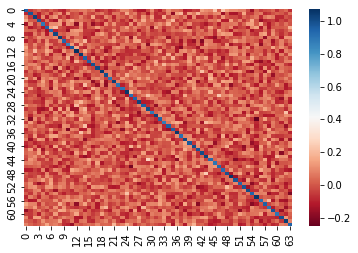

In [7]:
import seaborn as sns

sns.heatmap(adj, cmap='RdBu')

<AxesSubplot:>

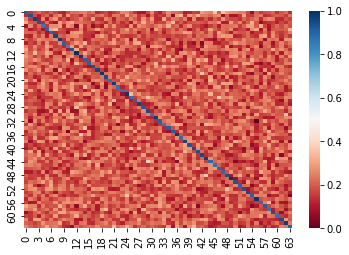

In [8]:
adj_scaled = (adj - adj.min()) / (adj.max() - adj.min())

sns.heatmap(adj_scaled, cmap='RdBu')

In [ ]:
import pandas as pd
channel_names = pd.read_csv('dataset/physionet.org_csv_full_imagine/S001_imagine.csv')
channel_names = channel_names.columns[3:].values
idc = [i for i in range(len(channel_names))]
channel_map = {idc[i]: channel_names[i] for i in range(len(channel_names))}

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def adj2edgelist(adj):
    edge_list = []
    for u in range(len(adj)):
        for v in range(len(adj)):
            if adj[u, v] == 0:
                continue
            elif adj[u, v] < 0:
                edge_list.append([u, v, 'r', adj[u, v]])
            else:
                edge_list.append([u, v, 'b', adj[u, v]])
    return edge_list

def plot_adj_as_graph(adj_mat, threshold, channel_names):
    np.fill_diagonal(adj_mat, 0)
    adj_mat = np.where(abs(adj_mat) > threshold, adj_mat, 0)
    adj_mat = np.round(adj_mat, 2)

    edge_list = adj2edgelist(adj_mat)

    G = nx.DiGraph()
    for (u, v, color, weight) in edge_list:
        G.add_edge(u, v, color=color, weight=weight)
    G.add_nodes_from(channel_names)

    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*20 for u,v in edges]
    plt.figure(figsize=(10, 7))
    
    G = nx.relabel_nodes(G, {idc[i]: channel_names[i] for i in range(len(channel_names))})

    ch_pos_1010 = get_sensor_pos(channel_names)
    coor = np.array(list(ch_pos_1010.values()))

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    coor = pca.fit_transform(coor)
    pos = {}
    for idx, (k, v) in enumerate(ch_pos_1010.items()):
        pos[k] = coor[idx].tolist()

    # nx.draw_networkx_nodes(G, pos=pos, alpha=0.1)
    nx.draw(G, pos=pos, with_labels=True, node_size=600, edge_color=colors, width=weights)
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f'Threshold (%): {int(threshold*100)}')
    plt.show()

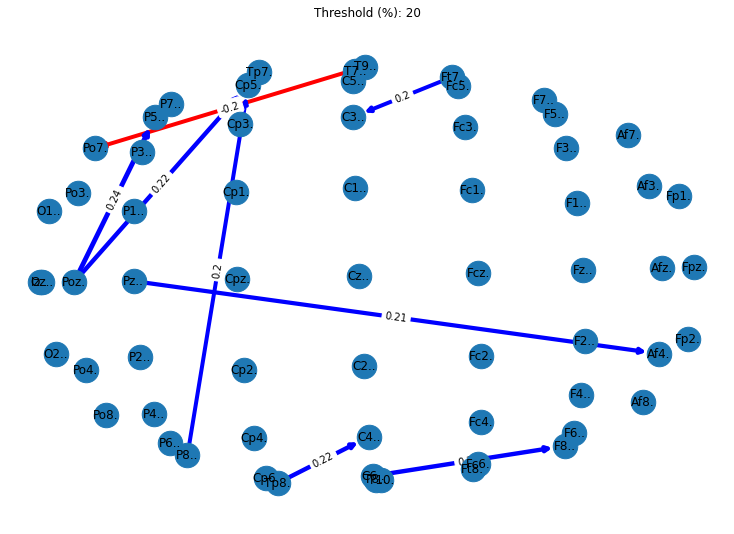

In [ ]:
plot_adj_as_graph(adj, 0.2, channel_names)

In [ ]:
from graph_utils import get_sensor_pos

ch_pos_1010 = get_sensor_pos(list(channel_map.values()))

In [ ]:
coor = np.array(list(ch_pos_1010.values()))

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

coor = pca.fit_transform(coor)

pos = {}
for idx, (k, v) in enumerate(ch_pos_1010.items()):
    pos[k] = coor[idx].tolist()

print(pos)

{'Fc5.': [0.0297982178500787, 0.07572631456978539], 'Fc3.': [0.03192688109519495, 0.05939512142100123], 'Fc1.': [0.034077928260336086, 0.034364538889165915], 'Fcz.': [0.035810611485777875, 0.0013770721920943125], 'Fc2.': [0.036677331659828366, -0.03157036310948431], 'Fc4.': [0.03662706415576633, -0.05790327487482039], 'Fc6.': [0.03582734444873831, -0.07439672717321019], 'C5..': [-0.0015907881750790466, 0.07765920806846395], 'C3..': [-0.001686457907524608, 0.06327313276187436], 'C1..': [-0.001084308197956747, 0.03523771873569648], 'Cz..': [4.3446550960977346e-05, 0.00019342071864421193], 'C2..': [0.0016153215917784052, -0.03547307335113315], 'C4..': [0.0031201162387368905, -0.06361054268458106], 'C6..': [0.004351700788621429, -0.07916691765504996], 'Cp5.': [-0.03302188489139782, 0.07599781345555633], 'Cp3.': [-0.035515236057881844, 0.060468430032451635], 'Cp1.': [-0.03681459857127118, 0.03348152444065286], 'Cpz.': [-0.03633783507705943, -0.0009455716241872452], 'Cp2.': [-0.0343004698005